# Introducción

El presente cuaderno de Colab tiene por objetivo investigar y experimentar con distintas bibliotecas de Python y algoritmos de HPC.

Para esto, vamos a continuar con la temática que utilizamos en el trabajo de Android, donde mostramos la cantidad de casos de Covid19 que tiene un pais. 

El objetivo de la parte de Python es la extracción de datos de una api externa y visualizar los casos de Covid totales que fue teniendo Argentina en un tiempo previamente definido. 
Ademas, vamos a estar generando el archivo .CSV para el procesamiento del HPC

Las bibliotecas de python que vamos a estar usando son:
*   Numpy
*   MatPlotLib

Para la segunda parte vamos a estar usando OpenMP para paralelizar el calculo de casos promedios de Covid19 totales por pais. Si bien estamos utilizando un set de datos pequeño, está pensando para acelerar la ejecución calculandolo para cada país en un thread independiente.




# Armado de ambiente


No es necesario instalar librerias para ejecutar el cuaderno.

# Módulos Python


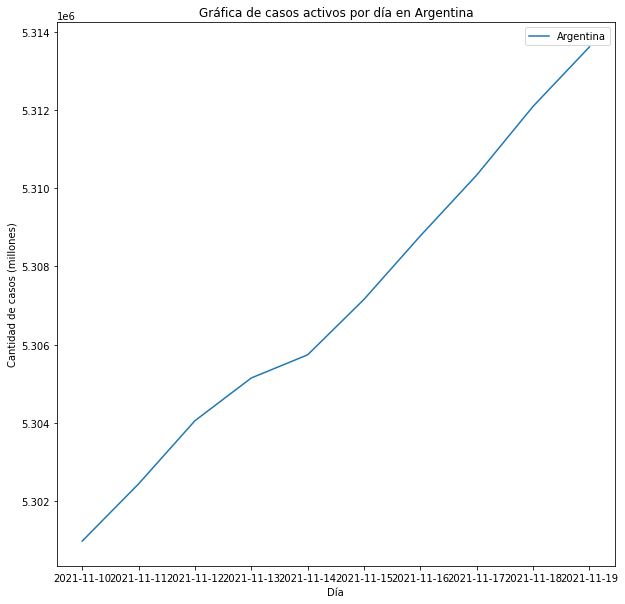

In [263]:
import requests
import json 
import matplotlib.pyplot as plt
from dateutil import parser
import numpy as np
import csv

countries = ["argentina", "uruguay", "brazil", "paraguay", "bolivia", "chile"]
dateFrom = "2021-11-10"
dateTo = "2021-11-19"

listaPaises = []
datosArgentina = []

for country in countries:
  url = "https://api.covid19api.com/country/"+ country +"/status/confirmed?from=" + dateFrom + "T00:00:01Z&to=" + dateTo + "T23:59:59Z"

  payload={}
  headers = {
  }

  response = requests.request("GET", url, headers=headers, data=payload)
  
  nombre = response.json()[0]["Country"]

  respuestaJson = response.json()
  for datos in respuestaJson:
    casos = datos["Cases"]
    fecha = datos["Date"]
    fecha = parser.parse(fecha)

    if(nombre == "Argentina"):
      datosArgentina.append([nombre, country, casos, fecha])

    listaPaises.append([nombre, country, casos, fecha])

x_val = [x[3] for x in datosArgentina]
y_val = [x[2] for x in datosArgentina]

np.savetxt("coviddata.csv", listaPaises, delimiter=";", fmt='%s', header="pais;slug;cases;day")

plt.figure(figsize=(10, 10))
plt.plot(x_val,y_val, label= "Argentina")

plt.title('Gráfica de casos activos por día en Argentina')
plt.xlabel('Día')
plt.ylabel('Cantidad de casos (millones)')

plt.legend()
plt.show()



# Uso de HPC


El algoritmo está dividido en dos partes. La primera es la que se encarga del setup de los datos. Para hacer esto tomamos el csv previamente generado y lo spliteamos. Para este ejercicio solo nos importa el nombre de los paises y la cantidad de casos. Guardamos todos los nombres de los paises en un array, y luego la cantidad de casos en una matriz que tiene pais x días.

En la segunda parte tenemos la ejecución en paralelo con los hilos de OpenMP. Donde cada hilo va a tomar un país y hacer el calculo. En este momento verán que ya dividimos por el total de días. Esto lo hicimos de esta manera para no hacer un overflow del int. Otro método podría haber sido usar un tipo de dato mas grande y hacer la división al final

Finalmente, mostramos los resultados obtenidos por pantalla

Para esta parte del ejericio, podríamos cambiar la cantidad de hilos que queremos planificar cambiando el valor de la variable de entorno OMP_NUM_THREADS.

Este algoritmo tiene varios puntos a mejorar, como por ejemplo que se autocalcule la cantidad de días y de países que tiene el CSV.


In [260]:
procesamiento_paralelo = """
  #include <iostream>
  #include <omp.h>
  #include <fstream>
  #include <sstream>

  #include <string>
  #define PAISES 6
  #define DIAS 10
  #define POS_NOMBRE 1
  #define POS_CASOS 2

  using namespace std;

  int main(int arg_qty, char* argv[]) 
  { 
    std::ifstream  data("coviddata.csv");
    std::string line;

    int casos[DIAS][PAISES];

    std::string nombres[PAISES];
    
    std::string nombre;

    int dia = 0;
    int pais = 0;
    int cantidadCasos = 0;
    int index = 0;
    int isHeader = 1;

    //Primera parte

    while(std::getline(data,line))
    {
        if(isHeader == 1)
        {
          isHeader = 0;
          continue;
        }

        std::stringstream lineStream(line);
        std::string cell;

        index = 0;
        while(std::getline(lineStream,cell,';'))
        {
            if(index == POS_NOMBRE)
            {
              nombre = cell;
            }

            if(index == POS_CASOS)
            {
              cantidadCasos = std::stoi( cell );
            }

            index ++;
        }

        casos[dia][pais] = cantidadCasos;
        nombres[pais] = nombre;

        dia ++;

        if(dia == DIAS)
        {
          dia = 0;
          pais ++;
        }
    }

    //Segunda parte

    int resultados[PAISES];
    float promedios;
    #pragma omp parallel for
    for(int i = 0; i < PAISES; i++){
      promedios=0;
      for(int j = 0; j < DIAS; j++){
        promedios+= ((casos[j][i]) / DIAS);
      }
      resultados[i] = promedios;
    }

    std::cout<<"Resultados "<<endl;
    for(int i = 0; i < PAISES; i++){ 
        std::cout<<nombres[i]<< ": " << resultados[i] <<std::endl;
    }
  }
      
"""
archivo = open("mult.cpp", "w")
archivo.write(procesamiento_paralelo)
archivo.close()

In [261]:
!g++ -o covid19 -fopenmp  mult.cpp

In [262]:
%env OMP_NUM_THREADS=2
!./covid19

env: OMP_NUM_THREADS=2
Resultados 
Argentina: 5307030
Uruguay: 396641
Brazil: 21958224
Paraguay: 461837
Bolivia: 524021
Chile: 1726948


# Conclusiones

Durante esta ejercitación pudimos explorar el funcionamiento de varios módulos de Python y poner en práctica la teória que vimos sobre OpenMP

Si bien no tuvimos experiencia previa en Python, la programación en este lenguaje resulta bastante fácil e intuitiva. Si bien el código que generamos no es tán extenso, pudimos resolverlo sin tener que buscar arduamente en la docuemtanción del lenguaje. Por otro lado, encontramos también que en la mayoría de los casos hay una biblioteca que se encarga de resolver el problema que estás necesitando resolver, de una manera simple y elegante.

La parte de C++ fue quizas donde todo no salió tan fácil debido a que es un lenguaje un poco mas rebuscado que Python, pero de todos modos no estaban haciendo algo tan complejo. Nos ocurrió que nos llevó mas tiempo resolver la lectura del csv que planificar los hilos con openMP

Por último, también a esto se le suma la experiencia de usar Google Colab. Creemos que solo vimos la punta del iceberg de todo lo que podemos lograr con esta herramienta, que sin duda la tendremos para resolver problemas de otro tipo en algún futuro


#Bibliografia

[1] Ejemplo de OpenMP: [Notebook](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%201%20-%20Vectores%20-%20OpenMP.ipynb)

[2] Uso de MatPlotLibt: [Documentación](https://matplotlib.org/stable/index.html)

[3] Leer de un CSV en C: [Ejemplo](https://stackoverflow.com/questions/1120140/how-can-i-read-and-parse-csv-files-in-c)

[4] Generar un CSV en Python: [Ejemplo](https://stackoverflow.com/questions/2084069/create-a-csv-file-with-values-from-a-python-list)
